In [ ]:
# !pip install transformers datasets accelerate evaluate bitsandbytes peft -q

In [10]:
import os
# Avoid deadlock warning from huggingface/tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import torch.nn.functional as F
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import bitsandbytes as bnb  # 8-bit ops and optimizer
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftConfig, PeftModel
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Use same seeds, ranks, etc. that you used in your original code
torch.manual_seed(42)

In [11]:
# Example LoRA config: Adjust to match your exact hyperparams
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,
    target_modules=["query", "value", "key", "output.dense"]  # typical for attention layers
)

# Example: bitsandbytes optimizer
# (If you used AdamW or something else, keep it the same as your original code)
optimizer_class = bnb.optim.Adam8bit

In [49]:
# Example: AG News dataset
dataset = load_dataset("ag_news")
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])

train_dataset = tokenized_dataset["train"]
test_dataset = tokenized_dataset["test"]
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [13]:
def load_lora_model(lora_model_path: str):
    """
    Loads a LoRA-finetuned RoBERTa model from a specified directory,
    along with the tokenizer.
    """
    # Load the PEFT config to identify the base model
    peft_config = PeftConfig.from_pretrained(lora_model_path)
    
    # Load the base model
    base_model = RobertaForSequenceClassification.from_pretrained(
        peft_config.base_model_name_or_path,
        num_labels=4  # for AGNews
    )
    # Attach LoRA adapters
    model = PeftModel.from_pretrained(base_model, lora_model_path)
    model.eval()
    
    # Load tokenizer from the same folder
    tokenizer = RobertaTokenizer.from_pretrained(lora_model_path)
    return model, tokenizer

lora_model_path = "./finetuned_roberta_large_lora"  # adjust to your path
teacher_model, teacher_tokenizer = load_lora_model(lora_model_path)

teacher_model.eval()  # teacher in eval mode
teacher_model.cuda()  # or .to(device) if using HPC

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A

In [14]:
student_model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=4
)
# Add LoRA
student_model = get_peft_model(student_model, lora_config)

# Freeze all base RoBERTa weights so only LoRA is trainable
for name, param in student_model.named_parameters():
    if "lora_" not in name:
        param.requires_grad = False

student_model.cuda()  # HPC GPU usage

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [15]:
trainable_params = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
print(f"Trainable student parameters (LoRA): {trainable_params}")
# Make sure this is <= 1e6


Trainable student parameters (LoRA): 958464


In [16]:
class DistillationTrainer(Trainer):
    def __init__(self, teacher, alpha_distill=0.5, temperature=2.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher
        self.alpha_distill = alpha_distill
        self.temperature = temperature
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels", None)
        
        # Student forward
        outputs_student = model(**inputs)
        student_logits = outputs_student.logits
        
        # Standard CE loss
        import torch.nn.functional as F
        ce_loss = F.cross_entropy(student_logits, labels)
        
        # Teacher forward (no grad)
        with torch.no_grad():
            outputs_teacher = self.teacher(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"]
            )
            teacher_logits = outputs_teacher.logits
        
        # Distillation loss (KL div)
        student_log_probs = F.log_softmax(student_logits / self.temperature, dim=-1)
        teacher_probs = F.softmax(teacher_logits / self.temperature, dim=-1)
        distill_loss = F.kl_div(
            student_log_probs, 
            teacher_probs, 
            reduction="batchmean"
        ) * (self.temperature ** 2)
        
        # Combine them
        loss = (1 - self.alpha_distill) * ce_loss + self.alpha_distill * distill_loss

        return (loss, outputs_student) if return_outputs else loss


In [17]:
training_args = TrainingArguments(
    output_dir="./distilled_roberta_lora",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=1e-4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    # If your older Transformers doesn’t support "evaluation_strategy", remove it or upgrade
    fp16=True,  # HPC often has half-precision
    report_to="none",
    label_names=["labels"]  # fixes "No label_names provided" warning
)

In [18]:
trainer = DistillationTrainer(
    teacher=teacher_model,
    alpha_distill=0.5,      # weight for teacher’s KL loss
    temperature=2.0,        # distillation temperature
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,       # if you used trainer's auto padding
    # data_collator=your_data_collator,
    optimizers=(None, None)    # or set your bitsandbytes optimizer here if needed
)

/tmp/ipykernel_6238/2431091360.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [19]:
trainer.train()
eval_metrics = trainer.evaluate()
print("Eval metrics:", eval_metrics)

Epoch,Training Loss,Validation Loss
1,0.248700,0.209213
2,0.217000,0.194493
3,0.215100,0.190322


KeyboardInterrupt: 

In [20]:
class_names = dataset["train"].features["label"].names
id2label = {i: label for i, label in enumerate(class_names)}

def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)
    prediction = output.logits.argmax(dim=-1).item()
    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [22]:
classify( student_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( student_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

In [23]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [26]:
from transformers import DataCollatorWithPadding

# Suppose you have a tokenizer already defined:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Check evaluation accuracy
_, _ = evaluate_model(student_model, test_dataset, True, 8, data_collator)

100%|██████████| 950/950 [00:22<00:00, 41.54it/s]

Evaluation Metric: {'accuracy': 0.9377631578947369}


In [30]:
import pandas as pd
device='cuda'  
wrong_predictions = []

# Create dataloader
eval_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=data_collator)
student_model.eval()
student_model.to('cuda')

# Collect wrong predictions
for batch in eval_dataloader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to('cuda')
    
    with torch.no_grad():
        outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=-1)
    
    for j in range(len(labels)):
        if preds[j] != labels[j]:
            wrong_predictions.append({
                "text": tokenizer.decode(input_ids[j], skip_special_tokens=True),
                "true_label": labels[j].item(),
                "predicted_label": preds[j].item()
            })

# Convert to DataFrame and save
wrong_df = pd.DataFrame(wrong_predictions)
if id2label:
    wrong_df["true_label_name"] = wrong_df["true_label"].map(id2label)
    wrong_df["predicted_label_name"] = wrong_df["predicted_label"].map(id2label)

wrong_df.to_csv("wrong_predictions.csv", index=False)
wrong_df.head()

,text,true_label,predicted_label,true_label_name,predicted_label_name
0,Some People Not Eligible to Get in on Google I...,3,2,Sci/Tech,Business
1,Live: Olympics day four Richard Faulds and Ste...,0,1,World,Sports
2,Intel to delay product aimed for high-definiti...,2,3,Business,Sci/Tech
3,Yahoo! Ups Ante for Small Businesses Web giant...,2,3,Business,Sci/Tech
4,Oil prices bubble to record high The price of ...,0,2,World,Business


In [34]:
output_dir = "results"

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

# Run inference and save predictions
preds = evaluate_model(student_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:25<00:00, 39.25it/s]


Inference complete. Predictions saved to inference_output.csv


In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [43]:
def show_confusion_matrix(model, dataset, tokenizer, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    student_model.eval().to(device)

    true_labels = []
    pred_labels = []

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to('cuda')

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

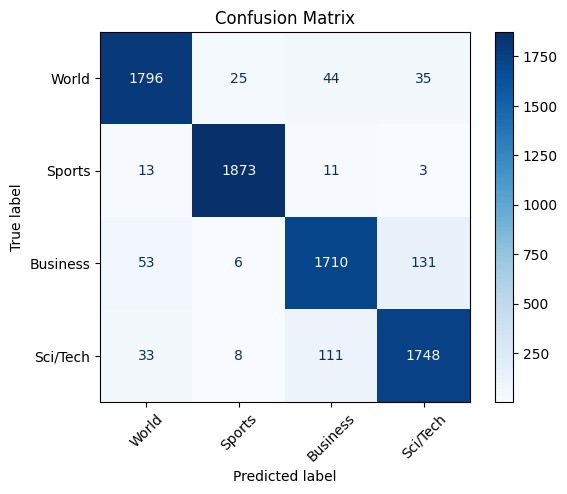

In [50]:
show_confusion_matrix(student_model, test_dataset, tokenizer)

In [51]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:02<00:00, 3415.77 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

In [52]:
# Run inference and save predictions
preds = evaluate_model(student_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:24<00:00, 40.10it/s]

Inference complete. Predictions saved to inference_output.csv


In [1]:
import shutil

# Zip the folder (this creates finetuned_roberta_large_lora.zip in your current working dir)
shutil.make_archive("finetuned_roberta_large_lora", "zip", "finetuned_roberta_large_lora")


'/scratch/ns6287/finetuned_roberta_large_lora.zip'

In [2]:
from IPython.display import FileLink

# Show clickable download link
FileLink("finetuned_roberta_large_lora.zip")

/scratch/ns6287/finetuned_roberta_large_lora.zip